In [1]:
import sys
from itertools import islice
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Local task dataloaders
sys.path.append('../')
from tasks import task_dataset

# load repe module
from repe import repe_pipeline_registry
repe_pipeline_registry()


/home/v-hazhong/anaconda3/envs/repe/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name_or_path = "/home/v-hazhong/Models/Llama-2-7b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

rep_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


In [4]:
batch_size = 32
max_length = 2048

rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'

In [5]:
# Define tasks and #shots here

# task, ntrain = 'obqa', 5
# task, ntrain = 'csqa', 7
task, ntrain = 'arc_challenge', 25
# task, ntrain = 'race', 3


dataset = task_dataset(task)(ntrain=ntrain)

Filter: 100%|██████████| 1119/1119 [00:00<00:00, 53609.14 examples/s]


In [6]:
# Build an unsupervised LAT PCA representation
direction_finder_kwargs= {"n_components": 1}
rep_reader = rep_pipeline.get_directions(
    dataset['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=dataset['train']['labels'], 
    direction_method=direction_method,
    direction_finder_kwargs=direction_finder_kwargs,
    batch_size=batch_size,
    max_length=max_length,
    padding="longest",
)

In [7]:
# Eval validation
results_val = {layer: {} for layer in hidden_layers}
labels = dataset['val']['labels']
H_tests = rep_pipeline(dataset['val']['data'],
                    rep_token=rep_token, 
                    hidden_layers=hidden_layers, 
                    rep_reader=rep_reader,
                    batch_size=8,
                    max_length=2048,
                    padding="longest")

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests] 
    unflattened_H_tests = [list(islice(H_test, sum(len(c) for c in labels[:i]), sum(len(c) for c in labels[:i+1]))) for i in range(len(labels))]

    sign = rep_reader.direction_signs[layer]
    eval_func = np.argmin if sign == -1 else np.argmax
    cors = np.mean([labels[i].index(1) == eval_func(H) for i, H in enumerate(unflattened_H_tests)])

    results_val[layer] = cors
    
    print(f"{layer} : {cors}")
    print("=====")    

-1 : 0.5886287625418061
=====
-2 : 0.5953177257525084
=====
-3 : 0.5886287625418061
=====
-4 : 0.5919732441471572
=====
-5 : 0.5953177257525084
=====
-6 : 0.5919732441471572
=====
-7 : 0.5919732441471572
=====
-8 : 0.5953177257525084
=====
-9 : 0.5953177257525084
=====
-10 : 0.6053511705685619
=====
-11 : 0.6053511705685619
=====
-12 : 0.6053511705685619
=====
-13 : 0.5986622073578596
=====
-14 : 0.5986622073578596
=====
-15 : 0.5953177257525084
=====
-16 : 0.6020066889632107
=====
-17 : 0.5986622073578596
=====
-18 : 0.5919732441471572
=====
-19 : 0.5852842809364549
=====
-20 : 0.5150501672240803
=====
-21 : 0.3076923076923077
=====
-22 : 0.26755852842809363
=====
-23 : 0.24749163879598662
=====
-24 : 0.25418060200668896
=====
-25 : 0.2608695652173913
=====
-26 : 0.25752508361204013
=====
-27 : 0.25418060200668896
=====
-28 : 0.22073578595317725
=====
-29 : 0.22742474916387959
=====
-30 : 0.25752508361204013
=====
-31 : 0.24414715719063546
=====


In [8]:
# Eval Test
results_test = {layer: {} for layer in hidden_layers}
labels = dataset['test']['labels']
H_tests = rep_pipeline(dataset['test']['data'], 
                    rep_token=rep_token, 
                    hidden_layers=hidden_layers, 
                    rep_reader=rep_reader,
                    batch_size=8,
                    max_length=2048,
                    padding="longest")

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests] 
    unflattened_H_tests = [list(islice(H_test, sum(len(c) for c in labels[:i]), sum(len(c) for c in labels[:i+1]))) for i in range(len(labels))]

    sign = rep_reader.direction_signs[layer]
    eval_func = np.argmin if sign == -1 else np.argmax
    cors = np.mean([labels[i].index(1) == eval_func(H) for i, H in enumerate(unflattened_H_tests)])

    results_test[layer] = cors
    
    print(f"{layer} : {cors}")
    print("=====") 

-1 : 0.6006825938566553
=====
-2 : 0.6015358361774744
=====
-3 : 0.6023890784982935
=====
-4 : 0.6040955631399317
=====
-5 : 0.6015358361774744
=====
-6 : 0.6023890784982935
=====
-7 : 0.6006825938566553
=====
-8 : 0.6032423208191127
=====
-9 : 0.6006825938566553
=====
-10 : 0.6075085324232082
=====
-11 : 0.6015358361774744
=====
-12 : 0.6023890784982935
=====
-13 : 0.6032423208191127
=====
-14 : 0.5998293515358362
=====
-15 : 0.5981228668941979
=====
-16 : 0.5972696245733788
=====
-17 : 0.6015358361774744
=====
-18 : 0.5947098976109215
=====
-19 : 0.6006825938566553
=====
-20 : 0.5418088737201365
=====
-21 : 0.33361774744027306
=====
-22 : 0.24488054607508533
=====
-23 : 0.2508532423208191
=====
-24 : 0.25597269624573377
=====
-25 : 0.2551194539249147
=====
-26 : 0.24061433447098976
=====
-27 : 0.23208191126279865
=====
-28 : 0.24658703071672355
=====
-29 : 0.24829351535836178
=====
-30 : 0.257679180887372
=====
-31 : 0.2619453924914676
=====


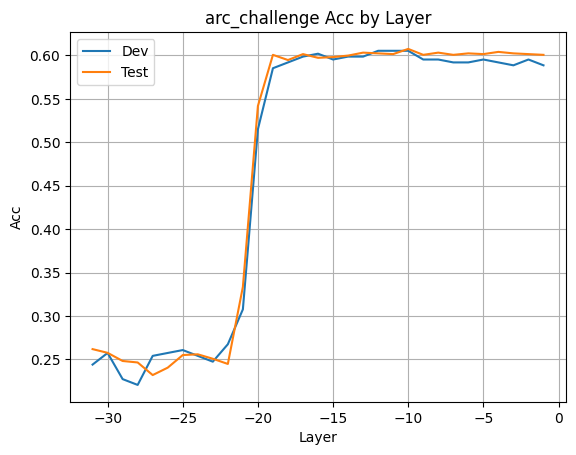

In [9]:
x = list(results_val.keys())
y_val = [results_val[layer] for layer in hidden_layers]
y_test = [results_test[layer] for layer in hidden_layers]


plt.plot(x, y_val, label="Dev")
plt.plot(x, y_test, label="Test")

plt.title(f"{task} Acc by Layer")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.legend()
plt.grid(True)
plt.show()